In [40]:
!pip install dataprep

In [41]:
!pip install xlrd==1.2.0

In [42]:
import pandas as pd
from dataprep.eda import *
from dataprep.datasets import load_dataset
from dataprep.eda import plot, plot_correlation, plot_missing, plot_diff, create_report
import numpy as np
import matplotlib.pyplot as plt
import statistics
from urllib.request import urlopen
import json
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

 


In [43]:
#importing the data

df_original = pd.read_excel('1952.xls')
df_original.drop(columns=['CaseID$'])
df=df_original.drop(columns=['CaseID$'])



WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
*** No CODEPAGE record, no encoding_override: will use 'ascii'
*** No CODEPAGE record, no encoding_override: will use 'ascii'


**EDA**

In [44]:
df.head(5)

CNAME  STCODE  CCODE  TOTPOP  ...  VLNTR_M  VLNTR_C  CGP_M  CGP_C
0       Hale, AL       1     65   20832  ...        0        0      0      0
1      Henry, AL       1     67   18674  ...        0        0      0      0
2    Houston, AL       1     69   46522  ...        0        0      0      0
3    Jackson, AL       1     71   38998  ...        0        0      0      0
4  Jefferson, AL       1     73  558928  ...        0        0    454     11

[5 rows x 234 columns]

In [45]:
#number of religions in the dataset

(len(df.columns)-6)/2

114.0

In [46]:
df.describe()

STCODE        CCODE  ...        CGP_M        CGP_C
count  3075.000000  3075.000000  ...  3075.000000  3075.000000
mean     30.373984    96.128130  ...     9.402276     0.321951
std      14.885946    86.417379  ...    29.639316     0.845838
min       1.000000     1.000000  ...     0.000000     0.000000
25%      19.000000    35.000000  ...     0.000000     0.000000
50%      29.000000    77.000000  ...     0.000000     0.000000
75%      45.000000   131.000000  ...     0.000000     0.000000
max      56.000000   510.000000  ...   454.000000    11.000000

[8 rows x 233 columns]

In [47]:
#unique US counties

len(df.CNAME.unique())

3075

In [48]:
#unique State Census Codes

len(df.STCODE.unique())

49

In [49]:
df.shape

(3075, 234)


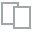
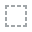
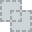
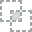
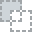
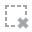
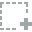
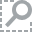
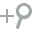
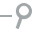
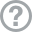
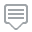
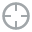
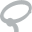
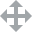
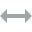
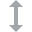
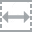
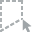
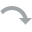
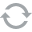
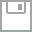
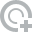
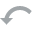
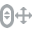
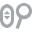
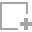
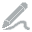
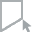
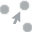
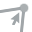
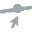

In [50]:
plot_missing(df)

In [51]:
print(f'Number of duplicate rows: {len(df)-len(df.drop_duplicates())}')

Number of duplicate rows: 0


In [52]:
#creating dataframe with churches info

columns=df.columns
matching = [s for s in columns if "_C" in s]

df_churches=df[['CNAME','TOTCHUR']+matching]
df_churches_T = df_churches.T 

df_churches_T.columns = df_churches_T.iloc[0]
df_counties_churches = df_churches_T.drop(['CNAME', 'TOTCHUR'] )



In [53]:
#creating dataframe with members info

c = df.columns
m = [s for s in columns if "_M" in s]

df_members=df[['CNAME','TOTMEMB']+m]
df_members_T = df_members.T 

df_members_T.columns = df_members_T.iloc[0]
df_counties_members = df_members_T.drop(['CNAME', 'TOTMEMB'] )


In [54]:
#checking for inconsistencies

#1) number of members should be <= total population for each county

df_faulty_1=df[df['TOTMEMB']>df['TOTPOP']]
print(f'There are {len(df_faulty_1)} counties where "number of members > total population"')


There are 15 counties where "number of members > total population"


In [55]:
#2) total no of members should be equal to the sum of religious members for each county

df_faulty_2=df_members[df_members['TOTMEMB']!=df_members[m].sum(axis = 1)]
print(f'There are {len(df_faulty_2)} counties where "total no of members is NOT equal to the sum of religious members"')



There are 0 counties where "total no of members is NOT equal to the sum of religious members"


In [56]:
#3) total no of churches should be = sum of churches of different religions for each county

df_faulty_3=df_churches[df_churches['TOTCHUR']!=df_churches[matching].sum(axis = 1)]
print(f'There are {len(df_faulty_3)} counties where "total no of churches is NOT equal to the sum of churches of different religions"')


There are 0 counties where "total no of churches is NOT equal to the sum of churches of different religions"


In [57]:
#4) checking for duplicates in terms of counties names

df.duplicated(subset='CNAME')


0       False
1       False
2       False
3       False
4       False
        ...  
3070    False
3071    False
3072    False
3073    False
3074    False
Length: 3075, dtype: bool

In [58]:
#5) checking for duplicates in terms of religions

len(df.columns)==len(np.unique(np.array(df.columns)))


True

**Visualizations**

In [59]:
#Churches distribution

#Create FIPS
df['STCODE_tmp'] = df['STCODE'].astype(str).str.zfill(2)
df['CCODE_tmp'] = df['CCODE'].astype(str).str.zfill(3)
df["FIPS"] = df["STCODE_tmp"].astype(str) + df["CCODE_tmp"].astype(str)
df.drop(['STCODE_tmp','CCODE_tmp'], axis=1,inplace=True)


tmp_df = df
tmp_df.drop(tmp_df.tail(1).index, inplace=True)
tmp_df = tmp_df[['CNAME','FIPS','TOTCHUR']]
display(tmp_df)
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

fig = px.choropleth(tmp_df, geojson=counties, locations='FIPS', color='TOTCHUR',
                           color_continuous_scale="Portland",
                           range_color=(0, 100),
                           scope="usa",
                            hover_data=['CNAME','TOTCHUR'],
                            title='Total number of churches per county',

                          )
fig.show()

CNAME   FIPS  TOTCHUR
0           Hale, AL  01065       52
1          Henry, AL  01067       31
2        Houston, AL  01069       88
3        Jackson, AL  01071       82
4      Jefferson, AL  01073      595
...              ...    ...      ...
3069  Sweetwater, WY  56037       22
3070       Teton, WY  56039        3
3071       Uinta, WY  56041        8
3072    Washakie, WY  56043       15
3073      Weston, WY  56045       13

[3074 rows x 3 columns]

In [60]:
#Religious members and total population ratio per county

#Create FIPS
df['STCODE_tmp'] = df['STCODE'].astype(str).str.zfill(2)
df['CCODE_tmp'] = df['CCODE'].astype(str).str.zfill(3)
df["FIPS"] = df["STCODE_tmp"].astype(str) + df["CCODE_tmp"].astype(str)
df.drop(['STCODE_tmp','CCODE_tmp'], axis=1,inplace=True)

#Percentage of members/population per county
tmp_df = df
tmp_df.drop(tmp_df.tail(1).index, inplace=True)
tmp_df['Percentage'] = tmp_df['TOTMEMB']/tmp_df['TOTPOP']
tmp_df = tmp_df[['CNAME','FIPS','Percentage']]
display(tmp_df)
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

fig = px.choropleth(tmp_df, geojson=counties, locations='FIPS', color='Percentage',
                           color_continuous_scale="Portland",
                           range_color=(0, 1),
                           scope="usa",
                            hover_data=['CNAME','Percentage'],
                            title='TOTMEMB:TOTALPOP',

                          )
fig.show()

CNAME   FIPS  Percentage
0           Hale, AL  01065    0.246976
1          Henry, AL  01067    0.255596
2        Houston, AL  01069    0.417437
3        Jackson, AL  01071    0.231550
4      Jefferson, AL  01073    0.379881
...              ...    ...         ...
3068    Sublette, WY  56035    0.073761
3069  Sweetwater, WY  56037    0.807149
3070       Teton, WY  56039    0.373313
3071       Uinta, WY  56041    0.520666
3072    Washakie, WY  56043    0.327910

[3073 rows x 3 columns]

**Orthodox Members**

In [61]:
#extracting the orthodox members for each county

info=pd.read_csv('info.csv')
info.fillna('0',inplace=True)
orth=info[info["Data File: CMS52CNT(Description Only Codebook)"].str.contains('Orthodox')]
index=orth.index
L=list(index)
M=[]
for i in L:
  n=i-1
  M.append(info.iloc[n])

orthodox_list=['ARAPO_M', 'ARAPO_C','GRKAD_M',
               'GRKAD_C','ACROC_M','ACROC_C','BEOC_M','BEOC_C']



In [62]:
#calculating the orthodox per person ratio

df_orthodox=df[['CNAME','TOTPOP','TOTMEMB']+orthodox_list]
df_orthodox['Total Orthodox members']=df_orthodox[orthodox_list].sum(axis = 1)
df_orthodox['Orthodox per person ratio']= df_orthodox['Total Orthodox members']/df_orthodox['TOTPOP']
df_orthodox.fillna(0,inplace=True)

df_orthodox.sort_values(by=['Orthodox per person ratio'], inplace=True,
                        ascending=False,
                         ignore_index=True)

counties=[]
for i in range(10):
  counties.append(df_orthodox.iloc[i,0])

print('The top 10 US counties w.r.t Orthodox members per person ratio are:',*counties, sep = "\n") 


df_orthodox[['CNAME','Orthodox per person ratio']].head(10)



The top 10 US counties w.r.t Orthodox members per person ratio are:
Cherokee, AL
Madison, IL
Fresno, CA
Racine, WI
Providence, RI
Allen, IN
Lorain, OH
Rensselaer, NY
Calhoun, MI
Trumbull, OH


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

CNAME  Orthodox per person ratio
0    Cherokee, AL                   0.011398
1     Madison, IL                   0.002309
2      Fresno, CA                   0.002289
3      Racine, WI                   0.001962
4  Providence, RI                   0.001739
5       Allen, IN                   0.001366
6      Lorain, OH                   0.001363
7  Rensselaer, NY                   0.001312
8     Calhoun, MI                   0.001250
9    Trumbull, OH                   0.000956

**Church distribution across religions**

In [63]:
#Extreme counties with respect to
#the distribution of their churches across religions

def find_outliers(data):
    outliers = []
    # Set upper and lower limit to 3 standard deviation
    data_std = statistics.stdev(data)
    data_mean = statistics.mean(data)
    cut_off = data_std * 3
    lower_limit  = data_mean - cut_off 
    upper_limit = data_mean + cut_off
    print(f'Lower limit: {lower_limit}')
    print(f'Upper limit: {upper_limit}')
    for d in data:
        if d > upper_limit or d < lower_limit:
            outliers.append(d)
    return len(outliers)




df_churches['Number of outliers'] = df_churches.apply(lambda row : find_outliers(row[2:]), axis = 1)
df_churches_outliers = df_churches.sort_values(by=['Number of outliers'], ascending=False ) 

df_churches_outliers[['CNAME','Number of outliers']].head(10)


Streaming output truncated to the last 5000 lines.
Lower limit: -6.870489070680412
Upper limit: 8.256453982961114
Lower limit: -3.2562639483171814
Upper limit: 3.905386755334725
Lower limit: -4.633165360616325
Upper limit: 5.773516237809308
Lower limit: -3.5139037357178724
Upper limit: 4.163026542735416
Lower limit: -4.301210064463306
Upper limit: 5.178403046919446
Lower limit: -9.17222032151977
Upper limit: 11.36520277766012
Lower limit: -5.839519731602001
Upper limit: 6.786888152654633
Lower limit: -2.732782934921179
Upper limit: 3.1889232857983716
Lower limit: -6.141278281118247
Upper limit: 7.264085298662106
Lower limit: -7.817199968077397
Upper limit: 9.115445582112486
Lower limit: -3.0546759632094584
Upper limit: 3.6862549105778797
Lower limit: -12.21157845620224
Upper limit: 14.001052140412767
Lower limit: -7.932812713142983
Upper limit: 9.424040783318421
Lower limit: -2.707020978464396
Upper limit: 3.1456174696924664
Lower limit: -5.115616710423877
Upper limit: 5.90509039463440

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



CNAME  Number of outliers
2892  Columbia, WA                  11
1214  Crawford, MI                  10
1262    Oscoda, MI                   9
885      Grant, KS                   9
268   Saguache, CO                   8
3056     Crook, WY                   8
2184    Harney, OR                   8
1641     Dawes, NE                   8
544      Lemhi, ID                   8
937      Scott, KS                   8

**Cross religion center**

In [64]:
def find_std(data):
    data_std = statistics.stdev(data)
    return data_std

df_members['STD'] = df_members.apply(lambda row : find_std(row[2:]), axis = 1)

df_cross_religion = df_members.sort_values(by=['STD'], ascending=False ) 

df_cross_religion[['CNAME','STD']].head(10)




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



CNAME            STD
574           Cook, IL  166594.669145
1815         Kings, NY  117461.976704
172    Los Angeles, CA   85534.092981
1276         Wayne, MI   71292.316402
2258  Philadelphia, PA   68804.683293
1794         Bronx, NY   66446.994524
1822      New York, NY   54223.949061
1832        Queens, NY   53837.158144
2209     Allegheny, PA   53725.278227
1189     Middlesex, MA   48134.937583